# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import joypy
from joypy import joyplot
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
figure_path = os.path.dirname(os.getcwd()) + '/figures'

In [3]:
molpatch_af_path = data_path + '/validation/molpatch/alphafold/'
molpatch_pdb_path = data_path + '/validation/molpatch/targets/'
patchprot = pd.read_csv(data_path + '/validation/patchprot/results.csv')

files_molpatch_af = [f for f in listdir(molpatch_af_path) if isfile(join(molpatch_af_path, f))]
files_molpatch_targets = [f for f in listdir(molpatch_pdb_path) if isfile(join(molpatch_pdb_path, f))]

# Import and preprocess MolPatch calculations

In [4]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_af[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_af_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    alphafold = pd.DataFrame(LHP_dict)

In [5]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_targets[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_pdb_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    pdbs = pd.DataFrame(LHP_dict)

# Merge files

In [6]:
pdbs['id'] = pdbs["id"].str[:-2]
pdbs['LHP_pdb'] = pdbs['LHP']
pdbs= pdbs[['id', 'LHP_pdb']]

alphafold['LHP_af'] = alphafold['LHP']
alphafold= alphafold[['id', 'LHP_af']]

patchprot['LHP_pp'] = patchprot['LHP_predicted']
patchprot['id'] = patchprot['ID']
patchprot = patchprot[['id', 'LHP_pp']]

patches = pd.merge(alphafold, patchprot, on='id', how='inner')
patches = pd.merge(patches, pdbs, on='id', how='inner')

In [7]:
patches = patches[patches['LHP_pp'] < 12000] # removing one protein which is clearly off skewing all the metrics

In [8]:
target_classes = pd.read_csv(data_path + '/validation/casp14/target_classes.csv')
patches_classes = pd.merge(target_classes, patches, left_on='Target', right_on='id', how='inner').drop(columns=['id'])

In [9]:
def patch_correlation(df):
    print('correlation between pdb and PatchProt')
    print(pearsonr(df['LHP_pp'], df['LHP_pdb']))
    print('correlation between alphafold and pdb')
    print(pearsonr(df['LHP_af'], df['LHP_pdb']))

In [10]:
patch_correlation(patches_classes)

correlation between pdb and PatchProt
(0.9270851730226669, 4.322461654298e-22)
correlation between alphafold and pdb
(0.9359034269521139, 2.166947222769507e-23)


# Compare

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_patch_comparisons(patches, figure_file):
    pdb = np.array(patches['LHP_pdb'])
    patchprot = np.array(patches['LHP_pp'])
    alphafold = np.array(patches['LHP_af'])
    classifications = patches['Classification']
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    
    unique_classes = np.unique(classifications)
    colors = plt.cm.get_cmap('viridis', len(unique_classes))
    
    for i, group in enumerate(unique_classes):
        idx = classifications == group
        mape_pp_group = mean_absolute_percentage_error(pdb[idx], patchprot[idx]) * 100
        mape_af_group = mean_absolute_percentage_error(pdb[idx], alphafold[idx]) * 100
    
        axs[0].scatter(pdb[idx], patchprot[idx], color=colors(i), alpha=0.4, label=f'{group} (MAPE={mape_pp_group:.1f}%)')
        axs[1].scatter(pdb[idx], alphafold[idx], color=colors(i), alpha=0.4, label=f'{group} (MAPE={mape_af_group:.1f}%)')
    
    axs[0].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)
    axs[0].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
    axs[0].set_ylabel('LHP ($Å^2$) PatchProt (predictions)')
    axs[0].set_title('PatchProt vs MolPatch')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)
    axs[1].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
    axs[1].set_ylabel('LHP ($Å^2$) MolPatch (AlphaFold)')
    axs[1].set_title('AlphaFold vs MolPatch')
    axs[1].grid(True)
    axs[1].legend()
    
    # figure_file = 'your_figure_file.png'  # Replace with your file path
    fig.savefig(figure_file, dpi=600, bbox_inches='tight')
    plt.show()

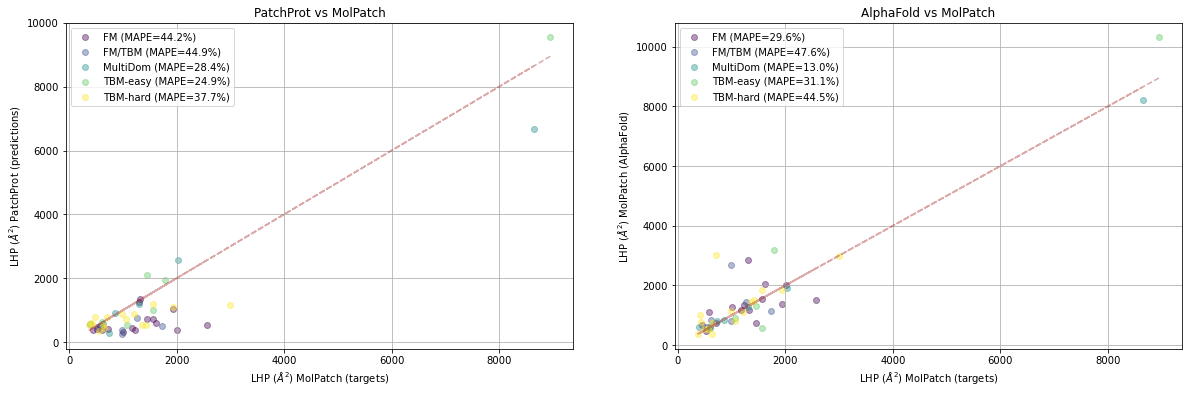

In [12]:
plot_patch_comparisons(patches_classes, figure_path + '/casp14_all_updated.png')

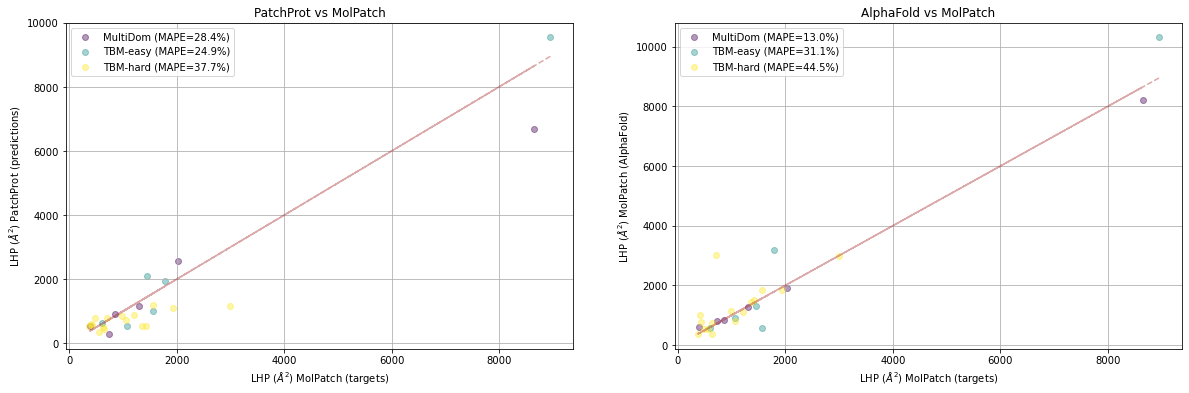

In [13]:
# No FM
filter_out_FM = patches_classes[patches_classes["Classification"].isin(['MultiDom', 'TBM-easy', "TBM-hard"])]
plot_patch_comparisons(filter_out_FM, figure_path + '/casp14_no_fm.png')

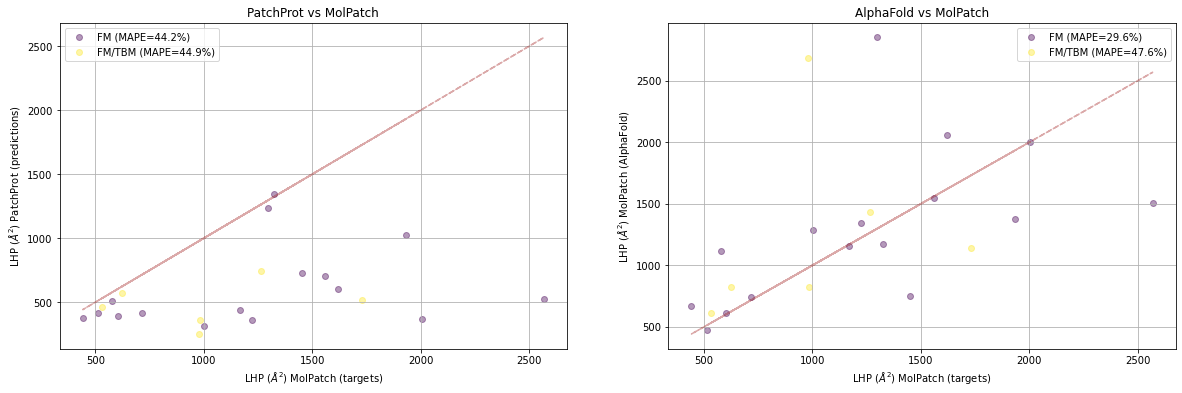

In [14]:
# only FM
filter_for_FM = patches_classes[patches_classes["Classification"].isin(['FM', 'FM/TBM'])]
plot_patch_comparisons(filter_for_FM, figure_path + '/casp14_only_fm.png')

# Check overlap with training data

In [124]:
training_pdb_list = pd.read_csv(data_path + '/patches/Train_LHP.csv')['PDB_ID'].apply(lambda x: x.split('-')[0]).to_list()
evaluate_pdb_list = patches_classes['PDB'].to_list()

In [125]:
# no intersection pdb's in the training and evaluation dataset
overlap = list(set(training_pdb_list) & set(evaluate_pdb_list))
if not overlap:
    print("No overlap with training data")

No overlap with training data
